# Weather forecasting using SARIMA model

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Reading the data, here's the link for the raw file on github:
https://github.com/jamoliddin05/weather_research/raw/main/tashkent.csv

# The dataset contains the monthly average temperatures from 1832 until 2012

In [2]:
tashkent = pd.read_csv('tashkent.csv')
tashkent['Date'] = pd.to_datetime(tashkent['Date'])
tashkent.set_index('Date', inplace=True)

#I will use the data from 1950 until 2012
tashkent = tashkent['1950':'2012']
tashkent_original = tashkent.copy()

# Plotting the data

In [3]:
def plot_series(series):
    plt.figure(figsize=(22,6))
    plt.plot(series)
    plt.ylabel('Temperature Variation in Tashkent', fontsize=16)

    start_year = series.index.min().year
    end_year = series.index.max().year
    for year in range(start_year, end_year + 1):
        plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    plt.axhline(0, linestyle='--', color='k', alpha=0.5)

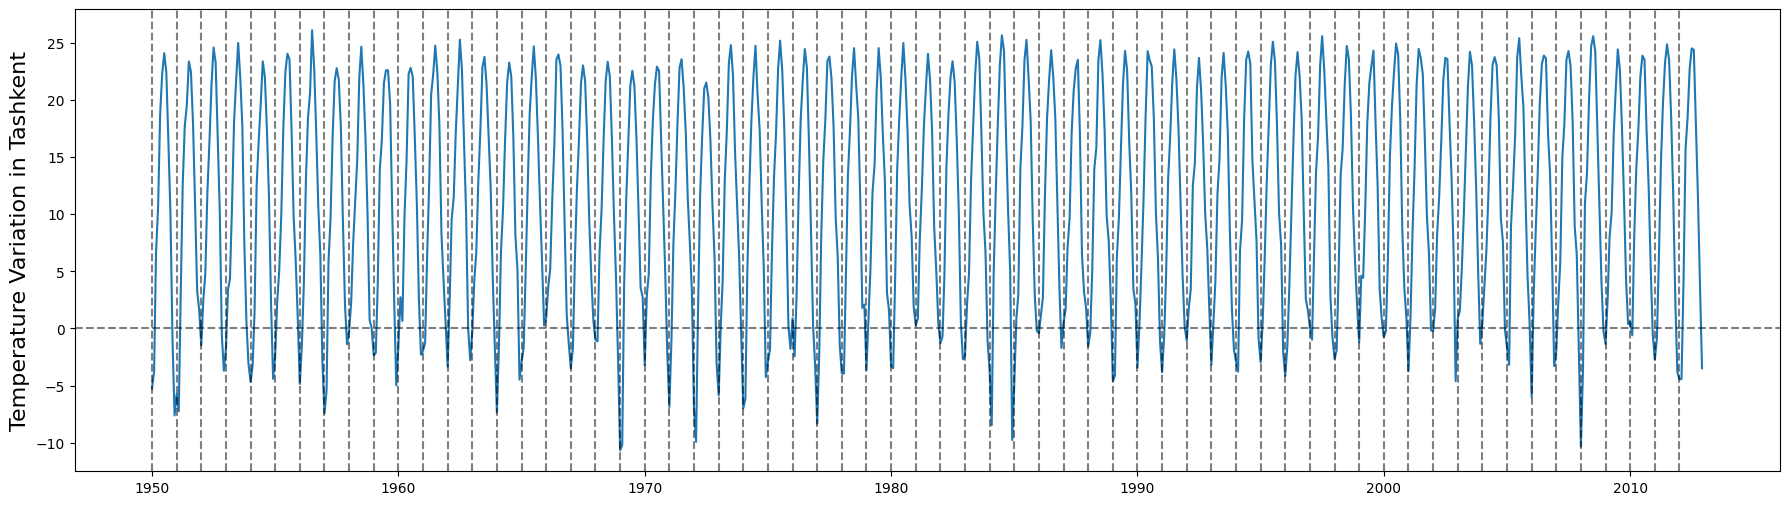

In [4]:
plot_series(tashkent)

# For the SARIMA model, I won't transform the series so I can get accurate ACF and PACF.

# I will just use the ADF test.

In [5]:
def check_stationarity(y):
    plot_series(y)
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)

    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

Results of Dickey-Fuller Test:
Test Statistic                  -6.3970
p-value                          0.0000
Lags Used                       17.0000
Number of Observations Used    738.0000
Critical Value (1%)             -3.4392
Critical Value (5%)             -2.8655
Critical Value (10%)            -2.5689
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


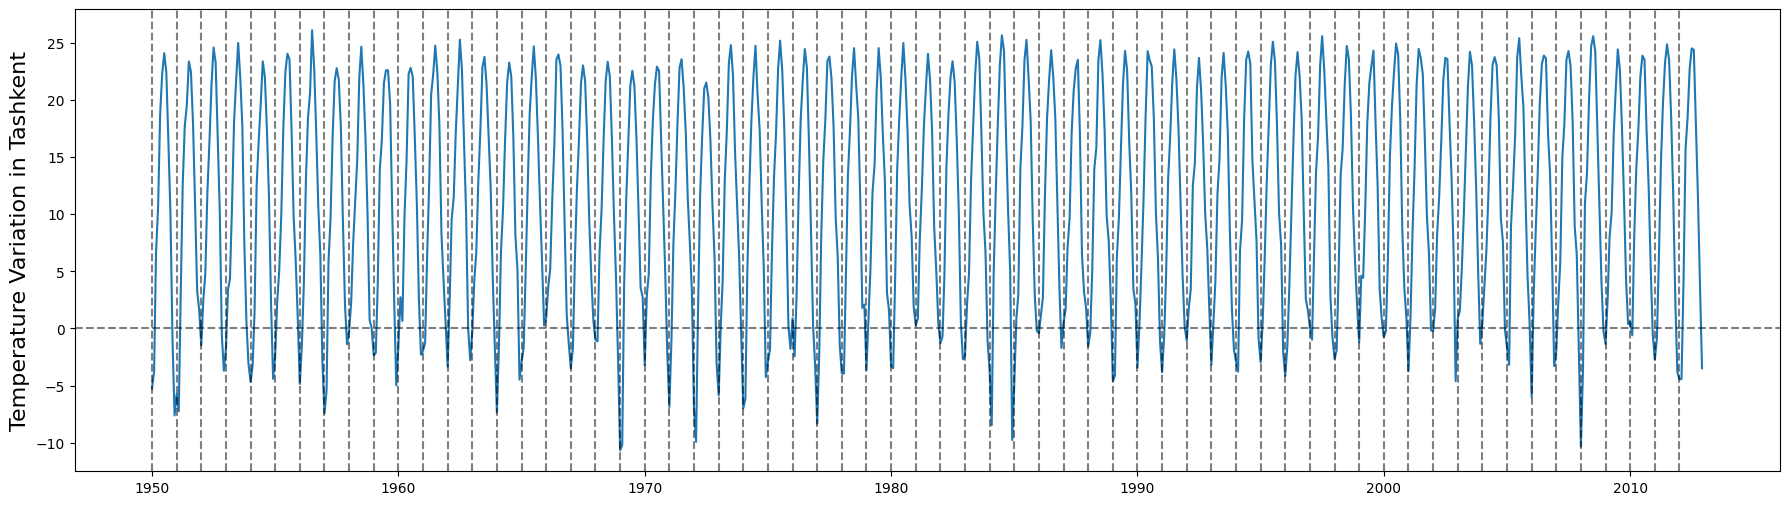

In [6]:
check_stationarity(tashkent)

# The serie is indeed stationary, so I can run the plot_acf and plot_pacf funcitons

In [7]:
def plot_correlation(y, lags_plots=20, figsize=(22,8)):
    "Use Series as parameter"
    
    # Creating plots of the DF
    fig = plt.figure(figsize=figsize)
    ax2 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
    ax3 = plt.subplot2grid((3, 3), (0, 1), colspan=1)

    plot_pacf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_acf(y, lags=lags_plots, zero=False, ax=ax3);

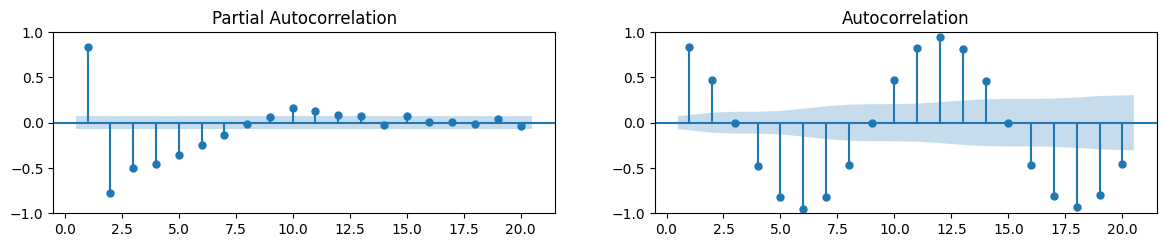

In [8]:
plot_correlation(tashkent)

# As the plots of 12th difference suggest I need to consider the Seasonal AR and MA parameters.

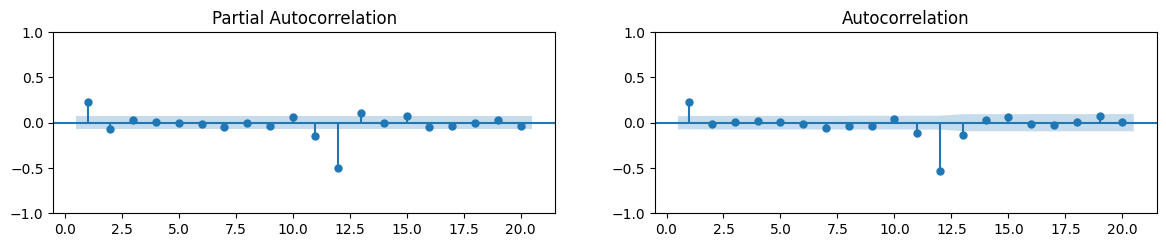

In [9]:
plot_correlation(tashkent.diff(12).dropna())

In [10]:
#Train_df will include the timestamps from 1950 up to 2008
#Model will be tested on the timestamps between 2008 and 2012
train = tashkent_original.iloc[:-60]
test = tashkent_original.iloc[-60:]

In [11]:
model = sm.tsa.statespace.SARIMAX(train, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12), trend='c')
result = model.fit(disp=False)

In [12]:
pred_start_date = test.index[0]
pred_end_date = test.index[-1]

In [13]:
test['usual_pred'] = result.predict(start=pred_start_date, end=pred_end_date)

In [14]:
def plot_forecast(actual, predictions):
    plt.figure(figsize=(15, 4))
    accuracy = (r2_score(actual, predictions) * 100).round(1)

    plt.plot(actual, color='blue')
    plt.plot(predictions, color='red')

    plt.title('Forecast VS Actual Temperature\n' + 'Accuracy: ' + str(accuracy) + '%' , fontsize=20)
    plt.ylabel('Temperature')
    plt.legend(('Temperature', 'Forecast'))

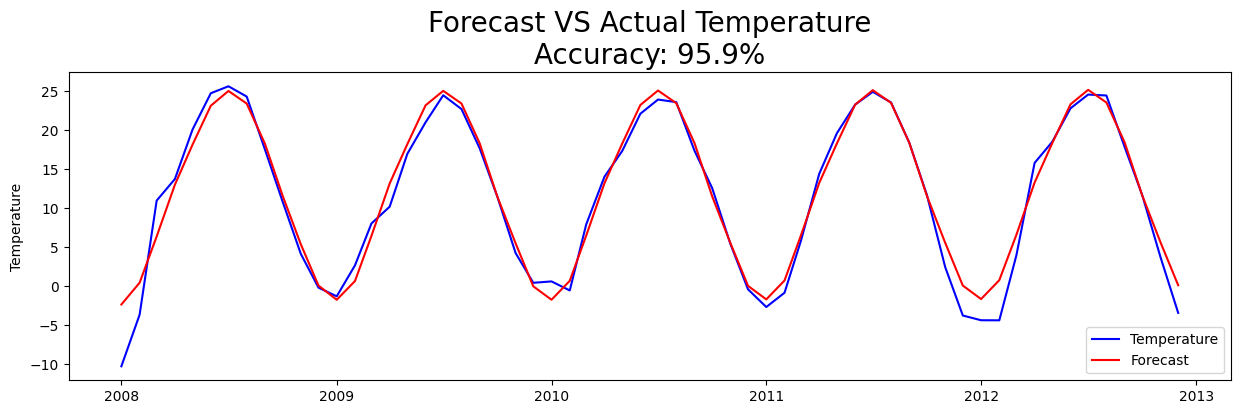

In [15]:
plot_forecast(test['Temp'], test['usual_pred'])

# Now, I will use the walk_forward method, to increase the accuracy

In [16]:
def walk_forward(train, test, order, seasonal_order, trend=None):
    # Initialize an empty list to store predictions
    predictions = []
    
    # Loop through the timestamps in the test set
    for timestamp in test.index:
        # Fit a SARIMAX model on the training data
        model = sm.tsa.statespace.SARIMAX(train, order=order, seasonal_order=seasonal_order, trend=trend)
        result = model.fit(disp=False)
        
        # Make a one-step forecast
        yhat = result.predict(start=timestamp, end=timestamp)[0]
        
        # Append the forecasted value to the list of predictions
        predictions.append(yhat)
        
        # Add the true value from the test set to the training set for the next iteration
        train.loc[timestamp] = test.loc[timestamp]
    
    # Return the list of predictions
    return pd.Series(predictions, index=test.index)

In [17]:
test['walk_pred'] = walk_forward(train, test, (2, 1, 2), (1, 1, 1, 12))

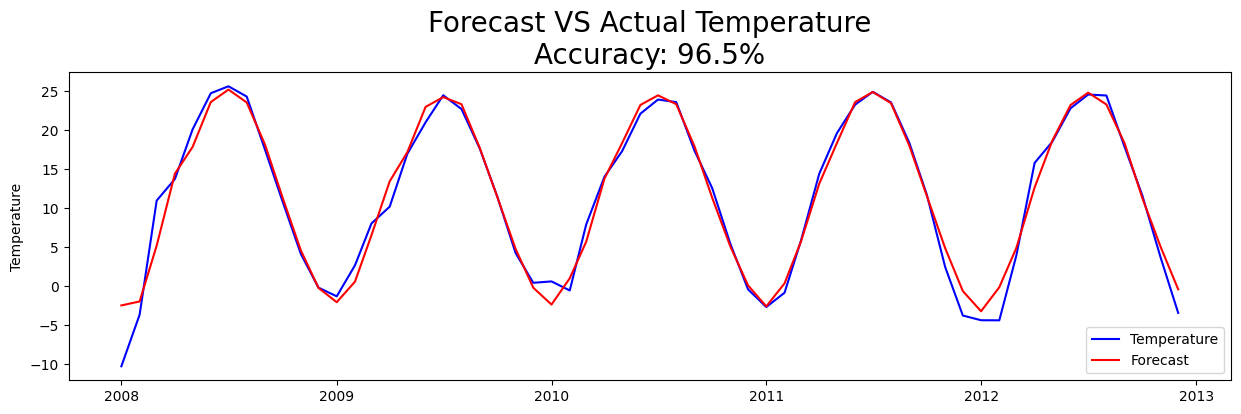

In [19]:
plot_forecast(test['Temp'], test['walk_pred'])

# As you can see, I got a little better forecast, but in case of SARIMA the usual prediction is more than enough.